In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from neo4j import GraphDatabase

from itertools import combinations
from collections import defaultdict
import json
import pprint

print(pd.__version__)

1.4.3


In [2]:
user = 'neo4j'
password = 'projectS01'
driver = GraphDatabase.driver("bolt://localhost:7687", auth=(user, password))

# Carga y limpieza de datos

In [2]:
path = '../data/Notas_2012_2019.xlsx'
data = pd.read_excel(path, skiprows=6)
data.head()

,folioproy,paterno,materno,nombre1,Calidad,Area Estudio,Institucion Patrocinante,Nota_proy,Año Concurso,Instrumento
0,11121114,HOLTHEUER,BEAUSIRE,CAROLINA,INVEST. RESPONSABLE,"LINGUISTICA,LITERATU",UNIV.DE CHILE,4.303,2012,INICIACION
1,11121115,THEZA,MANRIQUEZ,MARCEL,INVEST. RESPONSABLE,SOCIOLOGIA CS I,UNIV.DE LOS LAGOS,3.887,2012,INICIACION
2,11121118,LIBEDINSKY,SILVA,NICOLAS,INVEST. RESPONSABLE,MATEMATICAS,UNIV.DE CHILE,4.825,2012,INICIACION
3,11121122,CASTAÑEDA,GONZALEZ,ALVARO,INVEST. RESPONSABLE,MATEMATICAS,UNIV.DE CHILE,3.655,2012,INICIACION
4,11121123,CANDINA,POLOMER,AZUN,INVEST. RESPONSABLE,HISTORIA,UNIV.DE CHILE,4.303,2012,INICIACION


Hay investigadores in apellido materno (columna `materno` con valores `NaN`), por lo que al contruir el nombre completo concatenando `nombre1`, `materno` y `paterno`, resultará en un `NaN` aún cuando los demás valores no lo sean. Reemplazaremos los valores `NaN` de `materno` con un *string* vacío.

In [3]:
data['materno'].fillna('', inplace=True)
data['nombre_completo'] = data['nombre1'].str.title() + ' ' + data['paterno'].str.title() + ' ' + data['materno'].str.title()
data['Area Estudio'] = data['Area Estudio'].str.lower()
data['Nota_proy'].fillna(1., inplace=True) # el 1. es arbitrario, no sé la escala de notas
data['Institucion Patrocinante'] = data['Institucion Patrocinante'].apply(lambda u_name: f"{u_name.partition('.')[0].title()}. {u_name.partition('.')[2].strip().title()}")
data.rename(columns={'Area Estudio': 'area_estudio',
                     'Institucion Patrocinante': 'institucion_patrocinante',
                    'Año Concurso': 'año_concurso',
                    'Nota_proy': 'nota_proyecto',
                    'Instrumento': 'instrumento',
                    'Calidad': 'calidad'},
            inplace=True)

In [5]:
data.to_csv("./proyectos_fondecyt_2012-2019.csv", index=None)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8798 entries, 0 to 8797
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   folioproy                 8798 non-null   int64  
 1   paterno                   8798 non-null   object 
 2   materno                   8798 non-null   object 
 3   nombre1                   8798 non-null   object 
 4   Calidad                   8798 non-null   object 
 5   area_estudio              8798 non-null   object 
 6   institucion_patrocinante  8798 non-null   object 
 7   Nota_proy                 8798 non-null   float64
 8   año_concurso              8798 non-null   int64  
 9   Instrumento               8798 non-null   object 
 10  nombre_completo           8798 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 756.2+ KB


# Análisis exploratorio

## Universidades: ¿Cuántas hay y cuáles son?

¿Cuántas universidades hay?

In [5]:
data['institucion_patrocinante'].unique().shape

(47,)

## Áreas de estudio: ¿Cuántas hay y cuáles son?

¿Cuántas áreas de estudio hay?

In [56]:
data['area_estudio'].unique().shape[0]

28

In [57]:
data['area_estudio'].unique()

array(['linguistica,literatu', 'sociologia cs i', 'matematicas',
       'historia', 'biologia 2', 'educacion', 'cs. juridicas y pol.',
       'salud prod anim', 'cs. de la tierra', 'fisica teorica y exp',
       'medicina g2-g3', 'cs. econom/admi', 'ingenieria 1',
       'ingenieria 3', 'ingenieria 2', 'quimica 1', 'biologia 3',
       'quimica 2', 'geografia y urbanism', 'antrop. y arque',
       'artes y arquitectura', 'medicina g1', 'agronomia', 'sicologia',
       'biologia 1', 'astron.,cosmol.y par', 'filosofia', 'quimica'],
      dtype=object)

In [58]:
data['area_estudio'].value_counts()

medicina g2-g3          710
medicina g1             661
ingenieria 2            505
sociologia cs i         439
quimica 1               431
biologia 3              415
cs. juridicas y pol.    407
educacion               401
biologia 2              370
quimica 2               349
sicologia               324
ingenieria 1            313
matematicas             300
linguistica,literatu    292
ingenieria 3            286
biologia 1              268
fisica teorica y exp    267
historia                252
agronomia               238
astron.,cosmol.y par    232
geografia y urbanism    215
cs. de la tierra        209
cs. econom/admi         207
antrop. y arque         188
filosofia               187
artes y arquitectura    171
salud prod anim         153
quimica                   8
Name: area_estudio, dtype: int64

## Investigadores

¿Cuántos investigadores hay en el *dataset*?

In [9]:
data['nombre_completo'].unique().shape

(4660,)

¿Investigadores que han participado en más de una universidad?

In [10]:
universidades_x_inv = data.groupby(['nombre_completo'])['institucion_patrocinante'].count().sort_values(ascending=False)
display(universidades_x_inv.nlargest(30))
display(universidades_x_inv.mean())

nombre_completo
Marcelo Andia Kohnenkampf         12
Alexis Kalergis Parra             11
Jose Santos Martin                11
Ricardo Simpson Rivera            10
Alvaro Peña Neira                  9
Marco Arrese Jimenez               9
Ricardo Uauy Dagach                9
Jaime Silva Concha                 9
Patricio Moreno Moncada            9
Camila Corvalan Aguilar            9
Juan Maya Arango                   9
Maria Garmendia Miguel             8
Claudio Aguero San Juan            8
Emma Hernandez Rios                8
Susan Bueno Ramirez                8
Julio Romero Figueroa              8
Sergio Uribe Arancibia             8
Ulrike Kemmerling Weis             7
Claudio Garcia Herrera             7
Mehrdad Yazdani-Pedram Zobeiri     7
Emilio Herrera Videla              7
Rodrigo Pacheco Rivera             7
Marcelo Kogan Bocian               7
Silvana Zanlungo Matsuhiro         7
Alberto Diaz Araya                 7
Floreal Olea Carrasco              7
Pablo Pasten Gonzalez 

1.8879828326180257

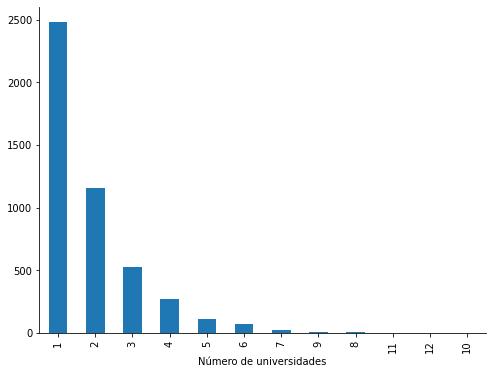

In [11]:
inv_x_universidad = universidades_x_inv.value_counts()
_, ax = plt.subplots(figsize=(8, 6))
inv_x_universidad.plot(kind='bar', ax=ax, xlabel='Número de universidades')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

¿Y cuál es la situación por año?

In [12]:
data.groupby(['año_concurso', 'nombre_completo'])['institucion_patrocinante'].count().nlargest(15)

año_concurso  nombre_completo        
2013          Alexis Kalergis Parra      4
2017          Ramon Palma Vasquez        4
2019          Claudio Olea Azar          4
2012          Felipe Simon Pino          3
              Marcel Clerc Gavilan       3
              Ricardo Armisen Yañez      3
2013          Claudio Fuentes Bravo      3
              Maria Pertusa Pastor       3
              Norbel Galanti Garrone     3
              Paulina Pavez Guerrero     3
              Sergio Uribe Arancibia     3
2014          Jaime Cisternas Elgueta    3
              Jorge Silva Sanchez        3
              Marco Mendez Torres        3
2015          Alberto Diaz Araya         3
Name: institucion_patrocinante, dtype: int64

Los investigadores presentes en el *dataset* ¿Han participado de más un área de estudio?

In [18]:
areas_estudio_x_inv = data.groupby(['nombre_completo'])['area_estudio'].count().sort_values(ascending=False)
areas_estudio_x_inv

nombre_completo
Marcelo Andia Kohnenkampf       12
Alexis Kalergis Parra           11
Jose Santos Martin              11
Ricardo Simpson Rivera          10
Alvaro Peña Neira                9
                                ..
Manuel Sanchez Uribe             1
Delia Chiarello Peñaranda        1
Manuel Valenzuela Valderrama     1
Deborah Steele                   1
Aaron Cortes Rojas               1
Name: area_estudio, Length: 4660, dtype: int64

In [19]:
areas_estudio_x_inv.value_counts()

1     2477
2     1153
3      527
4      275
5      114
6       70
7       27
9        7
8        6
11       2
12       1
10       1
Name: area_estudio, dtype: int64

Número de proyectos por investigador:

In [20]:
data.groupby(['nombre_completo'])['folioproy'].count().nlargest(10)

nombre_completo
Marcelo Andia Kohnenkampf    12
Alexis Kalergis Parra        11
Jose Santos Martin           11
Ricardo Simpson Rivera       10
Alvaro Peña Neira             9
Camila Corvalan Aguilar       9
Jaime Silva Concha            9
Juan Maya Arango              9
Marco Arrese Jimenez          9
Patricio Moreno Moncada       9
Name: folioproy, dtype: int64

Proyectos por universidad:

In [12]:
data["folioproy"].nunique()

5380

## Proyectos y sus áreas de investigación por universidad

In [24]:
nproyectos_universidad = data.groupby(["institucion_patrocinante"])["folioproy"].count().sort_values(ascending=False)
nproyectos_universidad

institucion_patrocinante
Univ. De Chile                               2782
Pont. Univ. Catolica De Chile                2460
Univ. De Santiago De Chile                    709
Univ. Andres Bello                            380
Univ. Diego Portales                          284
Univ. De Los Andes                            218
Univ. Adolfo Ibanez                           190
Univ. Alberto Hurtado                         185
Univ. De Concepcion                           144
Univ. Tecnica Federico Santa Maria            126
Univ. Austral De Chile                        121
Univ. Autonoma De Chile                       118
Pont. Univ. Catolica De Valparaiso            118
Univ. Del Desarrollo                          116
Univ. Mayor                                   106
Univ. De Talca                                 79
Univ. De La Frontera                           66
Univ. De Valparaiso                            58
Univ. Academia De Humanismo Cristiano          55
Univ. Catolica Del Norte 

In [26]:
nproyectos_universidad / nproyectos_universidad.sum()

institucion_patrocinante
Univ. De Chile                               0.316208
Pont. Univ. Catolica De Chile                0.279609
Univ. De Santiago De Chile                   0.080586
Univ. Andres Bello                           0.043192
Univ. Diego Portales                         0.032280
Univ. De Los Andes                           0.024778
Univ. Adolfo Ibanez                          0.021596
Univ. Alberto Hurtado                        0.021028
Univ. De Concepcion                          0.016367
Univ. Tecnica Federico Santa Maria           0.014321
Univ. Austral De Chile                       0.013753
Univ. Autonoma De Chile                      0.013412
Pont. Univ. Catolica De Valparaiso           0.013412
Univ. Del Desarrollo                         0.013185
Univ. Mayor                                  0.012048
Univ. De Talca                               0.008979
Univ. De La Frontera                         0.007502
Univ. De Valparaiso                          0.006592
Uni

In [40]:
nproyectos_universidad_json = nproyectos_universidad.to_json(None, "table")
pprint.pprint(json.loads(nproyectos_universidad_json), indent=2)

{ 'data': [ {'folioproy': 2782, 'institucion_patrocinante': 'Univ. De Chile'},
            { 'folioproy': 2460,
              'institucion_patrocinante': 'Pont. Univ. Catolica De Chile'},
            { 'folioproy': 709,
              'institucion_patrocinante': 'Univ. De Santiago De Chile'},
            { 'folioproy': 380,
              'institucion_patrocinante': 'Univ. Andres Bello'},
            { 'folioproy': 284,
              'institucion_patrocinante': 'Univ. Diego Portales'},
            { 'folioproy': 218,
              'institucion_patrocinante': 'Univ. De Los Andes'},
            { 'folioproy': 190,
              'institucion_patrocinante': 'Univ. Adolfo Ibanez'},
            { 'folioproy': 185,
              'institucion_patrocinante': 'Univ. Alberto Hurtado'},
            { 'folioproy': 144,
              'institucion_patrocinante': 'Univ. De Concepcion'},
            { 'folioproy': 126,
              'institucion_patrocinante': 'Univ. Tecnica Federico Santa Maria'},
     

In [41]:
nproyectos_universidad.to_json("nproyectos_universidad.json", "table")

In [6]:
df_proyectos_x_universidad = data.groupby(["institucion_patrocinante"])[["folioproy", "area_estudio"]].agg({
    'folioproy': ['count'],
    'area_estudio': ['nunique', 'unique', pd.value_counts]
})
df_proyectos_x_universidad.columns = df_proyectos_x_universidad.columns.droplevel(0)
df_proyectos_x_universidad.head(4)

,count,nunique,unique,value_counts
institucion_patrocinante,,,,
Pont. Univ. Catolica De Chile,2460,28,"[matematicas, biologia 2, cs. juridicas y pol....","[349, 214, 160, 159, 119, 92, 92, 91, 89, 88, ..."
Pont. Univ. Catolica De Valparaiso,118,23,"[cs. de la tierra, agronomia, fisica teorica y...","[29, 11, 9, 8, 8, 7, 7, 6, 5, 4, 3, 3, 3, 2, 2..."
Univ. Academia De Humanismo Cristiano,55,8,"[historia, antrop. y arque, sociologia cs i, l...","[22, 13, 7, 5, 3, 2, 2, 1]"
Univ. Adolfo Ibanez,190,19,"[historia, biologia 3, fisica teorica y exp, c...","[29, 23, 22, 19, 11, 11, 11, 10, 9, 8, 7, 6, 6..."


In [10]:
proyectos_x_universidad_json = df_proyectos_x_universidad.to_json(None, "table")
# pprint.pprint(json.loads(proyectos_x_universidad_json), indent=2)

In [12]:
df_proyectos_x_universidad.to_json("./proyectos_x_universidad.json", "table")

In [12]:
universidad_a_proyectos_y_area = [
    {
        'institucion_patrocinante': nombre,
        'count': 0,
        'n_areas': 0,
        'areas': [
            {
                'area': '',
                'n_proyectos': 0
            }
        ]
    }
for nombre in df_proyectos_x_universidad.index]
universidad_a_proyectos_y_area

[{'institucion_patrocinante': 'Pont. Univ. Catolica De Chile',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Pont. Univ. Catolica De Valparaiso',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Univ. Academia De Humanismo Cristiano',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Univ. Adolfo Ibanez',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Univ. Alberto Hurtado',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Univ. Andres Bello',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Univ. Arturo Prat',
  'count': 0,
  'n_areas': 0,
  'areas': [{'area': '', 'n_proyectos': 0}]},
 {'institucion_patrocinante': 'Univ. Austral De Chile',

In [13]:
for row in df_proyectos_x_universidad.itertuples():
    for universidad in universidad_a_proyectos_y_area:
        if row[0] == universidad['institucion_patrocinante']:
            universidad['count'] = int(row[1])
            universidad['n_areas'] = int(row[2])
            
            if len(row[3]) < 2:
                universidad['areas'][0]['area'] = str(row[3])
                universidad['areas'][0]['n_proyectos'] = int(row[4])
            else:
                for area, n in zip(row[3], row[4]):
                    universidad['areas'].append({'area': str(area), 'n_proyectos': int(n)})

In [21]:
for i, u_data in enumerate(universidad_a_proyectos_y_area):
    lista_areas = u_data['areas']
    for j, proyectos_data in enumerate(lista_areas):
        if proyectos_data['area'] == '':
            print(proyectos_data)
            del universidad_a_proyectos_y_area[i]['areas'][j]

{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area': '', 'n_proyectos': 0}
{'area':

In [22]:
universidad_a_proyectos_y_area

[{'institucion_patrocinante': 'Pont. Univ. Catolica De Chile',
  'count': 2460,
  'n_areas': 28,
  'areas': [{'area': 'matematicas', 'n_proyectos': 349},
   {'area': 'biologia 2', 'n_proyectos': 214},
   {'area': 'cs. juridicas y pol.', 'n_proyectos': 160},
   {'area': 'salud prod anim', 'n_proyectos': 159},
   {'area': 'medicina g2-g3', 'n_proyectos': 119},
   {'area': 'sociologia cs i', 'n_proyectos': 92},
   {'area': 'ingenieria 1', 'n_proyectos': 92},
   {'area': 'ingenieria 2', 'n_proyectos': 91},
   {'area': 'quimica 1', 'n_proyectos': 89},
   {'area': 'biologia 3', 'n_proyectos': 88},
   {'area': 'quimica 2', 'n_proyectos': 86},
   {'area': 'linguistica,literatu', 'n_proyectos': 83},
   {'area': 'cs. de la tierra', 'n_proyectos': 81},
   {'area': 'medicina g1', 'n_proyectos': 78},
   {'area': 'geografia y urbanism', 'n_proyectos': 78},
   {'area': 'sicologia', 'n_proyectos': 76},
   {'area': 'ingenieria 3', 'n_proyectos': 74},
   {'area': 'educacion', 'n_proyectos': 72},
   {'ar

In [23]:
universidad_a_proyectos_y_area = {'data': universidad_a_proyectos_y_area}
with open('proyectos_x_universidad3.json', 'w') as outfile:
    json.dump(universidad_a_proyectos_y_area, outfile)

In [20]:
data.groupby(['nombre_completo', 'año_concurso'])['folioproy'].nunique()

nombre_completo         año_concurso
Aaron Cortes Rojas      2014            1
Abderrahim Hantoute     2015            2
                        2019            1
Abdoulaye Thiam         2016            1
                        2017            1
                                       ..
Ziomara Gerdtzen Hakim  2013            1
Zully Pedrozo Cibils    2013            1
                        2015            1
                        2016            1
                        2018            1
Name: folioproy, Length: 8071, dtype: int64

## Notas de los proyectos

In [59]:
data['Nota_proy'].describe()

count    8798.000000
mean       12.088318
std        23.712903
min         1.000000
25%         4.260000
50%         4.471500
75%         4.710000
max        99.600000
Name: Nota_proy, dtype: float64

In [61]:
data.groupby(['Instrumento'])['Nota_proy'].mean()

Instrumento
INICIACION        4.339141
POSTDOCTORADO     8.924731
REGULAR          14.124025
Name: Nota_proy, dtype: float64

## Tipo de instrumento

In [62]:
data['Instrumento'].value_counts()

REGULAR          6506
INICIACION       1307
POSTDOCTORADO     985
Name: Instrumento, dtype: int64

In [64]:
data.groupby(['nombre_completo'])['Instrumento'].value_counts()

nombre_completo         Instrumento  
Aaron Cortes Rojas      INICIACION       1
Abderrahim Hantoute     REGULAR          3
Abdoulaye Thiam         INICIACION       1
                        POSTDOCTORADO    1
Abel Aravena Zamora     POSTDOCTORADO    1
                                        ..
Zenaida Suarez Mayor    INICIACION       1
                        POSTDOCTORADO    1
Zi Chan                 POSTDOCTORADO    1
Ziomara Gerdtzen Hakim  REGULAR          1
Zully Pedrozo Cibils    REGULAR          4
Name: Instrumento, Length: 5490, dtype: int64

## Universidades y sus áreas de estudio

¿Cuáles son las universidades más diversas en áreas de estudio?

In [55]:
data.groupby(['institucion_patrocinante'])['area_estudio'].value_counts()

institucion_patrocinante       area_estudio        
Pont. Univ. Catolica De Chile  medicina g2-g3          349
                               medicina g1             214
                               educacion               160
                               ingenieria 2            159
                               ingenieria 1            119
                                                      ... 
Universidad De O'Higgins.      ingenieria 2              1
                               matematicas               1
                               salud prod anim           1
Universidad Sek.               historia                  1
                               linguistica,literatu      1
Name: area_estudio, Length: 555, dtype: int64

# Carga de datos a Neo4j

In [ ]:
queries_constraints = ['CREATE CONSTRAINT ON (u:University) ASSERT u.university_name IS UNIQUE',
                       'CREATE CONSTRAINT ON (p:Project) ASSERT p.folio IS UNIQUE',
                       'CREATE CONSTRAINT ON (a:Area) ASSERT a.study_area IS UNIQUE',
                       'CREATE CONSTRAINT ON (y:Year) ASSERT y.year IS UNIQUE',
                       'CREATE CONSTRAINT ON (r:Researcher) ASSERT r.name IS UNIQUE',
                       'CREATE CONSTRAINT ON (g:Grade) ASSERT g.quality IS UNIQUE']

def constraints(tx, query):
    tx.run(query)


with driver.session() as session:    
    for query in queries_constraints:
        session.write_transaction(constraints, query)

In [24]:
def add_project(tx, folio: int, score: float, type_study: str,university: str, area:str, year: int):
    query_projects = '''MERGE (p:Project {folio: $folio})
                        SET p.score = $score
                        SET p.type = $instrument
                        MERGE (u:University {name: $university_name})
                        MERGE (p)<-[s:SPONSORED_BY]-(u)
                        MERGE (c:Area {study_area: $area})
                        MERGE (p)-[a:APPLY_TO]->(c)
                        MERGE (y:YEAR {year: $year})
                        MERGE (p)-[:ADJUDICATED_IN]->(y)'''
    tx.run(query_projects, folio=folio, score=score, instrument=type_study, university_name=university, area=area, year=year)
    

def add_researcher(tx, folio: int, name: str, quality: str):
    query_researcher = '''MERGE (r:Researcher {name: $name})
                          WITH r
                          MATCH (project:Project) WHERE project.folio = $folio
                          WITH r, project
                          MERGE (r)-[:INVESTIGATOR_OF]->(project)
                          MERGE (g:Grade {quality: $quality})
                          MERGE (r)-[:RESPONSABILITY_TYPE]->(g)
                          '''
    tx.run(query_researcher, folio=folio, name=name, quality=quality)

In [25]:
i = 1
with driver.session() as session:
        for folio, group in data.groupby('folioproy'):
            session.write_transaction(add_project,
                                      folio=int(folio),
                                      score=float(group['Nota_proy'].values[0]), 
                                      type_study=group['Instrumento'].values[0],
                                      university=group['Institucion Patrocinante'].values[0],
                                      area=group['Area Estudio'].values[0],
                                      year=int(group['Año Concurso'].values[0]))
        
            for researcher, quality in zip(group['nombre_completo'], group['Calidad']):
                session.write_transaction(add_researcher, folio=int(folio), name=researcher, quality=quality)
        
            i += 1
            if i % 10 == 0:   
                print(f'{i} proyectos procesados')

10 proyectos procesados
20 proyectos procesados
30 proyectos procesados
40 proyectos procesados
50 proyectos procesados
60 proyectos procesados
70 proyectos procesados
80 proyectos procesados
90 proyectos procesados
100 proyectos procesados
110 proyectos procesados
120 proyectos procesados
130 proyectos procesados
140 proyectos procesados
150 proyectos procesados
160 proyectos procesados
170 proyectos procesados
180 proyectos procesados
190 proyectos procesados
200 proyectos procesados
210 proyectos procesados
220 proyectos procesados
230 proyectos procesados
240 proyectos procesados
250 proyectos procesados
260 proyectos procesados
270 proyectos procesados
280 proyectos procesados
290 proyectos procesados
300 proyectos procesados
310 proyectos procesados
320 proyectos procesados
330 proyectos procesados
340 proyectos procesados
350 proyectos procesados
360 proyectos procesados
370 proyectos procesados
380 proyectos procesados
390 proyectos procesados
400 proyectos procesados
410 proye

3230 proyectos procesados
3240 proyectos procesados
3250 proyectos procesados
3260 proyectos procesados
3270 proyectos procesados
3280 proyectos procesados
3290 proyectos procesados
3300 proyectos procesados
3310 proyectos procesados
3320 proyectos procesados
3330 proyectos procesados
3340 proyectos procesados
3350 proyectos procesados
3360 proyectos procesados
3370 proyectos procesados
3380 proyectos procesados
3390 proyectos procesados
3400 proyectos procesados
3410 proyectos procesados
3420 proyectos procesados
3430 proyectos procesados
3440 proyectos procesados
3450 proyectos procesados
3460 proyectos procesados
3470 proyectos procesados
3480 proyectos procesados
3490 proyectos procesados
3500 proyectos procesados
3510 proyectos procesados
3520 proyectos procesados
3530 proyectos procesados
3540 proyectos procesados
3550 proyectos procesados
3560 proyectos procesados
3570 proyectos procesados
3580 proyectos procesados
3590 proyectos procesados
3600 proyectos procesados
3610 proyect

In [30]:
driver.close()

# Networkx

In [21]:
data.columns

Index(['folioproy', 'paterno', 'materno', 'nombre1', 'Calidad', 'area_estudio',
       'institucion_patrocinante', 'Nota_proy', 'año_concurso', 'Instrumento',
       'nombre_completo'],
      dtype='object')

In [87]:
G_researches = nx.Graph()

In [88]:
for folio, group in data.groupby('folioproy'):
    researches = group['nombre_completo'].values.tolist()
    if len(researches) > 1:
        researches_edges = combinations(researches, 2)
        G_researches.add_edges_from(researches_edges)
    # else:
    #     G_researches.add_node(researches[0])
    
G_researches.number_of_nodes(), G_researches.number_of_edges()

(2700, 4759)

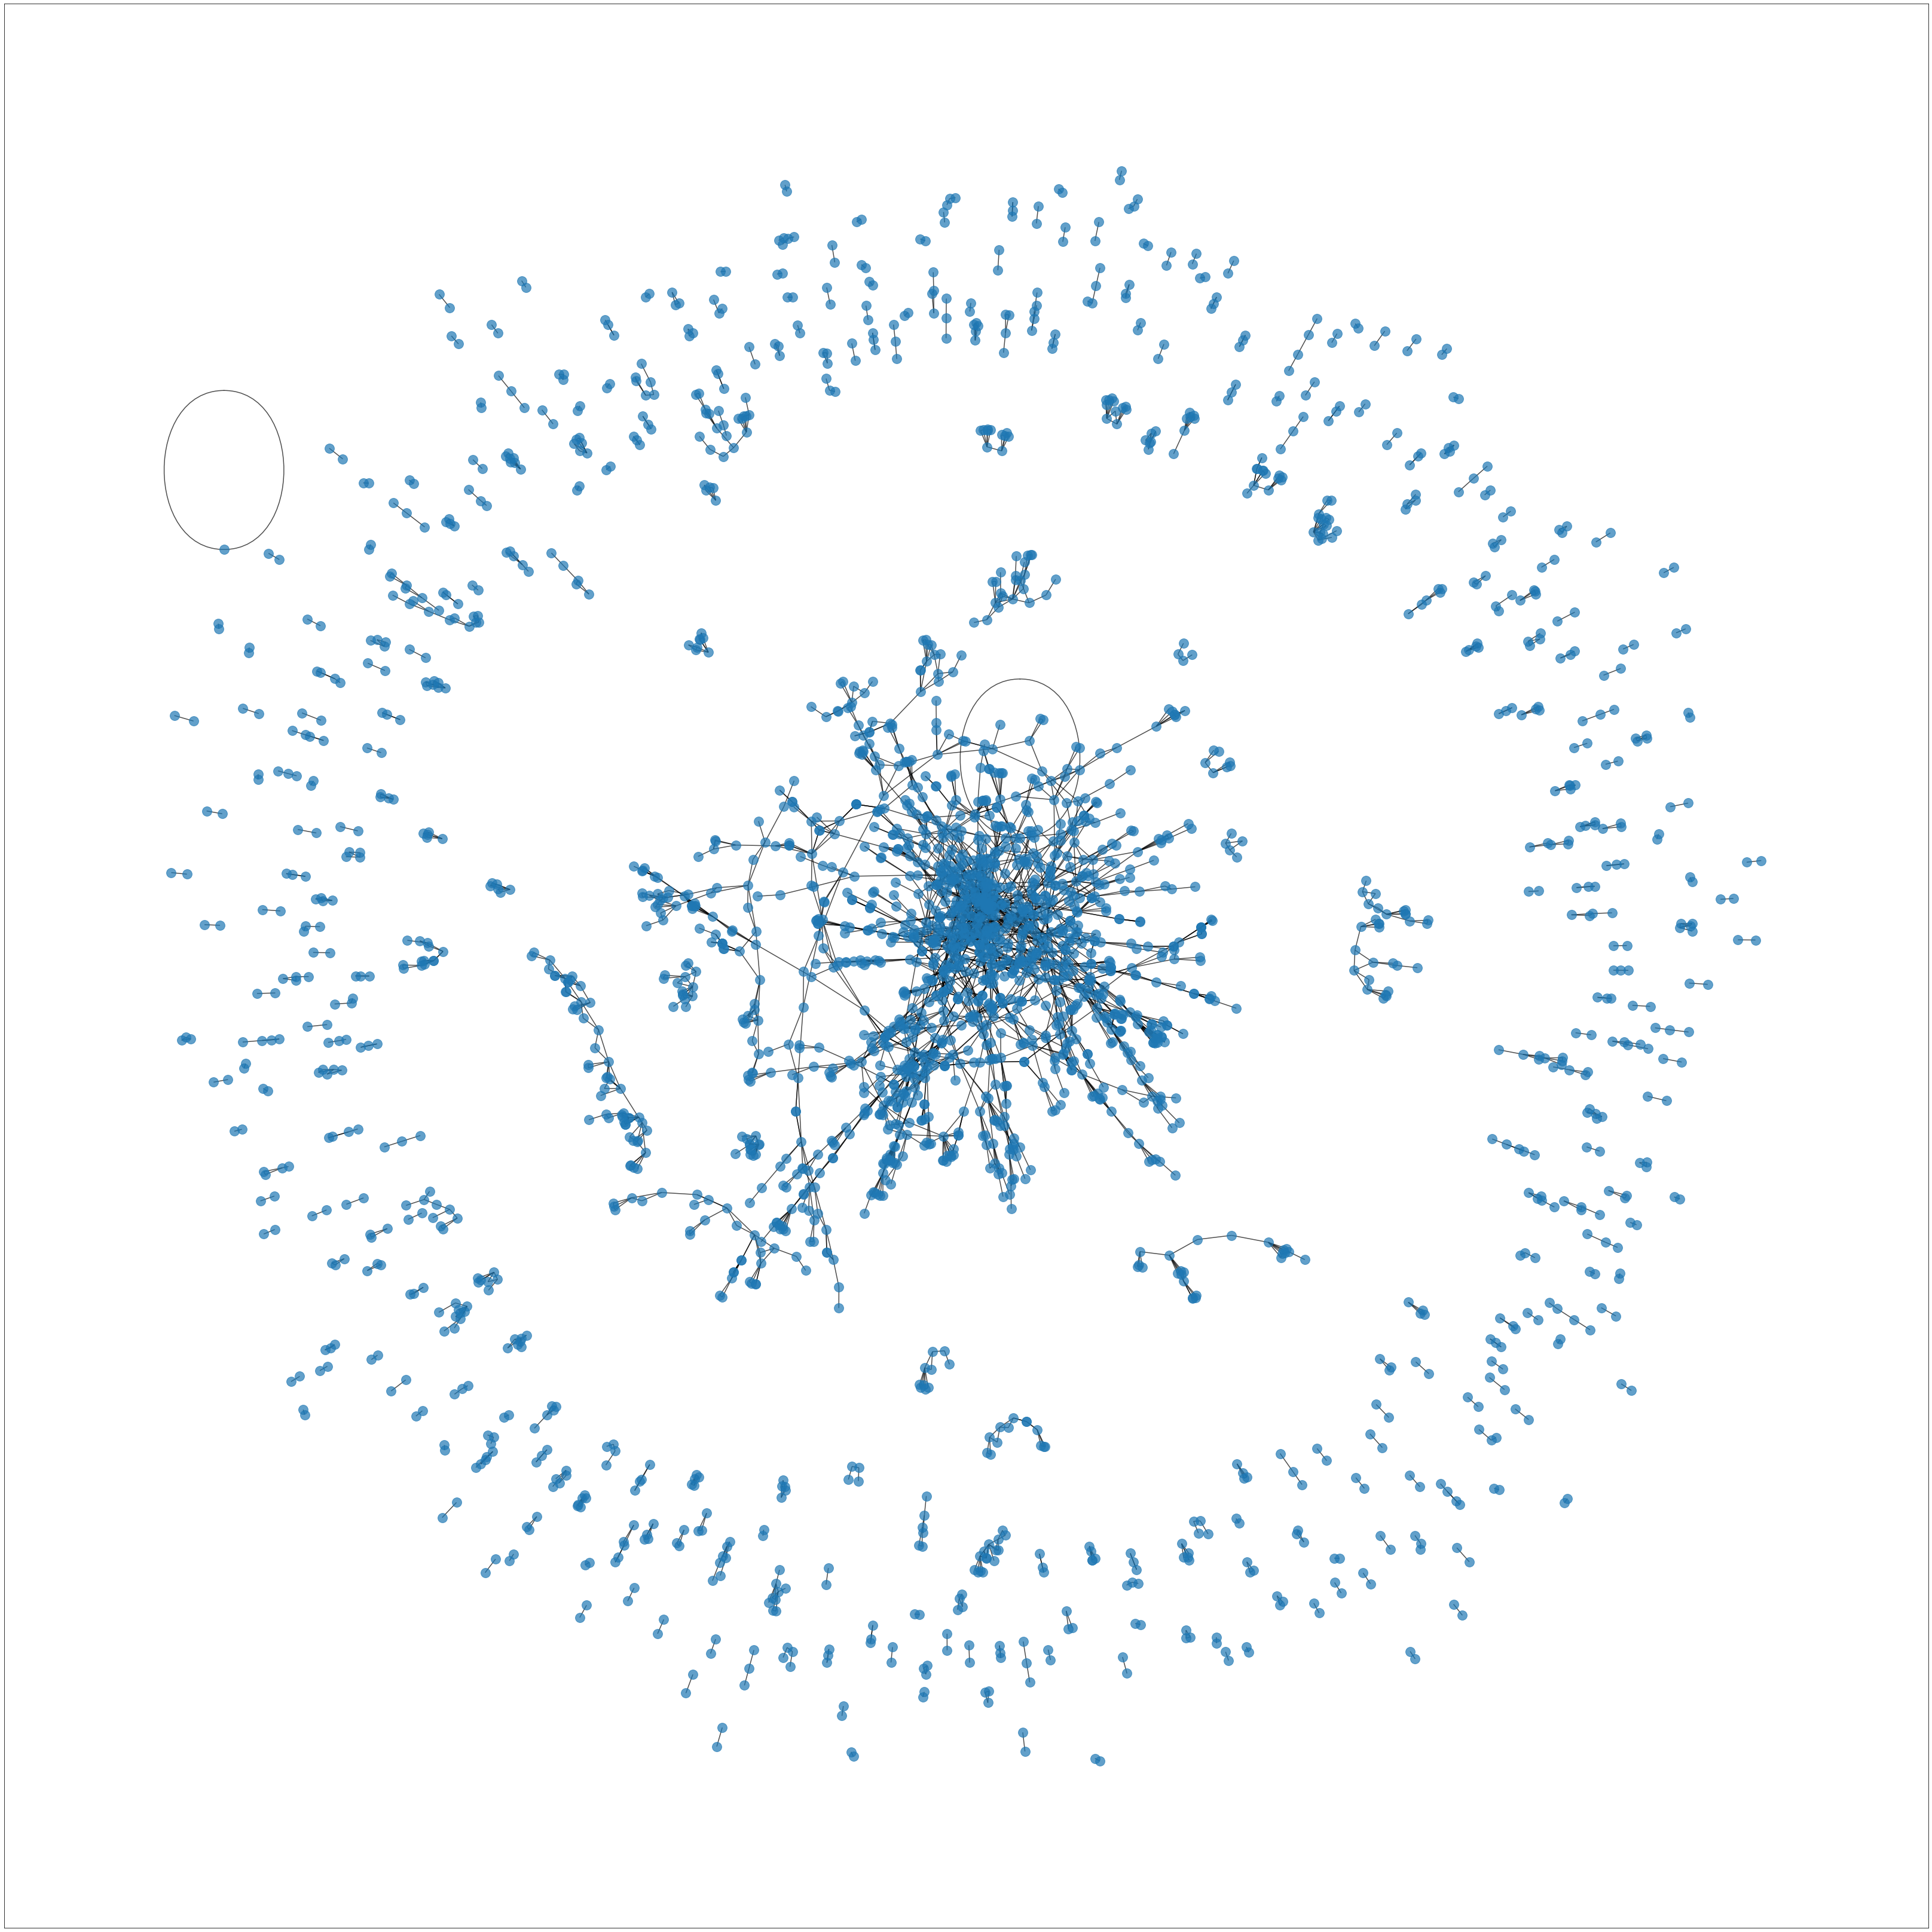

In [62]:
_, ax = plt.subplots(figsize=(45, 45), tight_layout=True)
pos = nx.spring_layout(G_researches)

nx.draw_networkx(G_researches, pos=pos, node_size=250, with_labels=False, width=1.5, alpha=0.7, ax=ax)

## *degree centrality* como propiedad de los nodos

In [89]:
nx.set_node_attributes(G_researches, dict(nx.degree(G_researches)), 'degree')

## Áreas de estudio por acádemico como propiedad de los nodos

In [90]:
agg_func_text = {'area_estudio': [ 'nunique', list]}
areas_estudio_por_academico = data.groupby(['nombre_completo']).agg(agg_func_text).reset_index().droplevel(0, axis=1)
areas_estudio_por_academico.columns = ['nombre_completo'] + areas_estudio_por_academico.columns[1:].values.tolist()
# areas_estudio_por_academico['set'] = areas_estudio_por_academico['set'].apply(lambda x: ", ".join(list(x)))
areas_estudio_por_academico.head()

,nombre_completo,nunique,list
0,Aaron Cortes Rojas,1,[medicina g2-g3]
1,Abderrahim Hantoute,1,"[matematicas, matematicas, matematicas]"
2,Abdoulaye Thiam,2,"[ingenieria 3, quimica]"
3,Abel Aravena Zamora,1,[filosofia]
4,Abel Guarda Moraga,1,"[ingenieria 3, ingenieria 3, ingenieria 3]"


In [91]:
academico_a_areas = {}
for row in areas_estudio_por_academico[['nombre_completo', 'list']].itertuples():
    # academico_a_areas[1] = academico_a_areas[2]
    academico_a_areas[row[1]] = row[2]

nx.set_node_attributes(G_researches, academico_a_areas, 'areas_estudio')

## Universidades por acádemico como propiedad de los nodos

In [92]:
agg_func_text = {'institucion_patrocinante': [ pd.unique, set, list]}
universidades_por_academico = data.groupby(['nombre_completo']).agg(agg_func_text).reset_index().droplevel(0, axis=1)
universidades_por_academico.columns = ['nombre_completo'] + universidades_por_academico.columns[1:].values.tolist()
universidades_por_academico['list_from_set'] = universidades_por_academico['set'].apply(lambda x: list(x))

academico_a_universidades = {}
for row in universidades_por_academico[['nombre_completo', 'list_from_set']].itertuples():
    academico_a_universidades[row[1]] = row[2]

nx.set_node_attributes(G_researches, academico_a_universidades, 'institucion_patrocinante')

## Número de proyectos por académico

In [93]:
agg_func_text = {'folioproy': ['nunique', set, list]}
proyectos_por_academico = data.groupby(['nombre_completo']).agg(agg_func_text).reset_index().droplevel(0, axis=1)
proyectos_por_academico.columns = ['nombre_completo'] + proyectos_por_academico.columns[1:].values.tolist()
# proyectos_por_academico['folioproy'] = proyectos_por_academico['folioproy'].apply(lambda x :str(x)).str.replace(r'[\[\]]', '', regex=True)
proyectos_por_academico['proyectos'] = proyectos_por_academico['set'].apply(lambda x: list(x))

academico_a_proyectos = {}
for row in proyectos_por_academico[['nombre_completo', 'nunique']].itertuples():
    academico_a_proyectos[row[1]] = row[2]

nx.set_node_attributes(G_researches, academico_a_proyectos, 'numero_proyectos')

## Nota promedio por académico

In [78]:
data.groupby(['nombre_completo'])['Nota_proy'].mean().nlargest(10)

nombre_completo
Rodrigo Scheihing Aguila       99.200
Ivan Conejeros Espinoza        98.200
Mickael Crampon                98.000
Leith Passmore                 96.200
Juan Ramirez Flores            95.400
German Barriga Gonzalez        94.200
Bernardo Colipan Filgueira     93.062
Rodrigo Verschae Tannenbaum    93.000
Julie Nantais                  92.800
Maria Poblete Segu             92.530
Name: Nota_proy, dtype: float64

## Proyectos por académico y año

In [94]:
proyectos_x_academico_año = data.groupby(['nombre_completo', 'año_concurso'])['folioproy'].nunique().to_frame().reset_index()
proyectos_x_academico_año.head(3)

,nombre_completo,año_concurso,folioproy
0,Aaron Cortes Rojas,2014,1
1,Abderrahim Hantoute,2015,2
2,Abderrahim Hantoute,2019,1


In [95]:
'''
academicos_a_proyectos_y_año = {nombre: [{"year": [], "count": []}] for nombre in proyectos_x_academico_año['nombre_completo'].unique()}

for row in proyectos_x_academico_año.itertuples():
    academicos_a_proyectos_y_año[row[1]][0]['year'].append(row[2])
    academicos_a_proyectos_y_año[row[1]][0]['count'].append(row[3])
'''
academicos_a_proyectos_y_año = {nombre: [] for nombre in proyectos_x_academico_año['nombre_completo'].unique()}

for row in proyectos_x_academico_año.itertuples():
    academicos_a_proyectos_y_año[row[1]].append({'year': row[2], "count": row[3]})

nx.set_node_attributes(G_researches, academicos_a_proyectos_y_año, 'proyectos_por_anio')

## Exportación del grafo de *Networkx* a `json`

In [97]:
data_json = nx.readwrite.json_graph.node_link_data(G_researches)
with open('graph_data_3.json', 'w') as out_file:
    json.dump(data_json, out_file)